In [25]:
import ase
from util_funcs import AtomsToGraphs, edge_feat
import util_funcs
from torch_geometric.utils import to_networkx, from_networkx
import numpy as np
import os
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from tqdm import tqdm
import matplotlib.pyplot as plt 
#from torch_geometric.data import DataLoader

In [2]:
a2g = AtomsToGraphs(
    max_neigh=50,
    radius=6,
    r_energy=True,
    r_forces=True,
    r_distances=True,
    r_edges=True,
    r_fixed=True,
)
i = 1
loc = os.getcwd()+"/s2ef_train_200K/{}.extxyz".format(i)
raw_data = ase.io.read(loc, ':')
data_0 = raw_data
graph_data = a2g.convert_all(data_0)

converting ASE atoms collection to graphs:   0%|          | 0/5000 [00:00<?, ? systems/s]C:\Users\Harshit\PycharmProjects\S2EF\util_funcs.py:183: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  cell = torch.Tensor(atoms.get_cell()).view(1, 3, 3)
converting ASE atoms collection to graphs: 100%|██████████| 5000/5000 [00:42<00:00, 116.90 systems/s]


In [3]:
graph_data[0]

Data(pos=[79, 3], cell=[1, 3, 3], atomic_numbers=[79], atomic_masses=[79], natoms=79, edge_index=[2, 3469], cell_offsets=[3469, 3], y=-537.61082559, force=[79, 3], distances=[3469], tags=[79], fixed=[79], x=[79, 9])

# Creating new relational edge-feature to control the message passing from the edges
----
> ## Edge-para (h)
>> It parameterise the edges on the basis of distance from one another; as the forces of neighbouring atom Atom2  far from the Atom1 have  very little influence on Atom1 also vice-versa.
<br> The force influence is inversely propotional to the distances.
<br> f ~ 1/A;   &emsp;  f = forces, A = Distances
<br> f = h/A or h = f*A
<br> for Atom1 --> h1 = avg(forces)* int(disctances)
<br> for Atom2 --> h2 = avg(forces)* int(disctances)
<br> h = (h1 + h2)/2

In [4]:
info =  graph_data[0].force.numpy()
print("max : {}, min : {}, avg : {}".format(np.max(info), np.min(info), np.average(info)))

max : 1.7899909019470215, min : -1.575884222984314, avg : -2.0119710342214603e-09


In [5]:
dis = graph_data[0].distances.numpy()
print("max : {} A, min : {} A, avg : {} A".format(np.max(dis), np.min(dis), np.average(dis)))
dis.shape

max : 5.9988274574279785 A, min : 0.964176595211029 A, avg : 4.4172186851501465 A


(3469,)

In [6]:
# Edge_feat function contains similar type of operations.
"""
z = np.zeros((graph_data[0].num_nodes, graph_data[0].num_nodes))
for i in range(len(graph_data[0].distances)):
    z[graph_data[0].edge_index[0, i],graph_data[0].edge_index[1, i] ] = graph_data[0].distances[i]

force_avrg = np.average(info, axis=-1)
f_d = np.diag(force_avrg)
h_ =  f_d@z
h = (h_ + h_.T)*0.5

l = list()
for i in graph_data[0].edge_index.t():
    l.append(h[i[0], i[1]])
"""

H = edge_feat(graph_data)

100%|██████████| 5000/5000 [03:29<00:00, 23.87it/s]


In [7]:
for i in range(len(graph_data)):
    graph_data[i].edge_attr = H[i] 

In [8]:
graph_data[50].pos[0],graph_data[50].x[0], 

(tensor([ 0.0721,  0.0965, 16.0583]),
 tensor([ 1.3000e+01,  2.6982e+01,  1.0000e+00,  7.2087e-02,  9.6534e-02,
          1.6058e+01,  1.3333e-02, -6.3110e-04, -2.5067e-02]))

In [9]:
# Converting PyG Graph into networkx graph to make a animates plot
i = 500
graph_data[i].edge_attr = H[i] 
g_1 = to_networkx(graph_data[i], node_attrs= ["pos","atomic_numbers", "force", "x" ],
                  edge_attrs= ["edge_attr", "cell_offsets"])

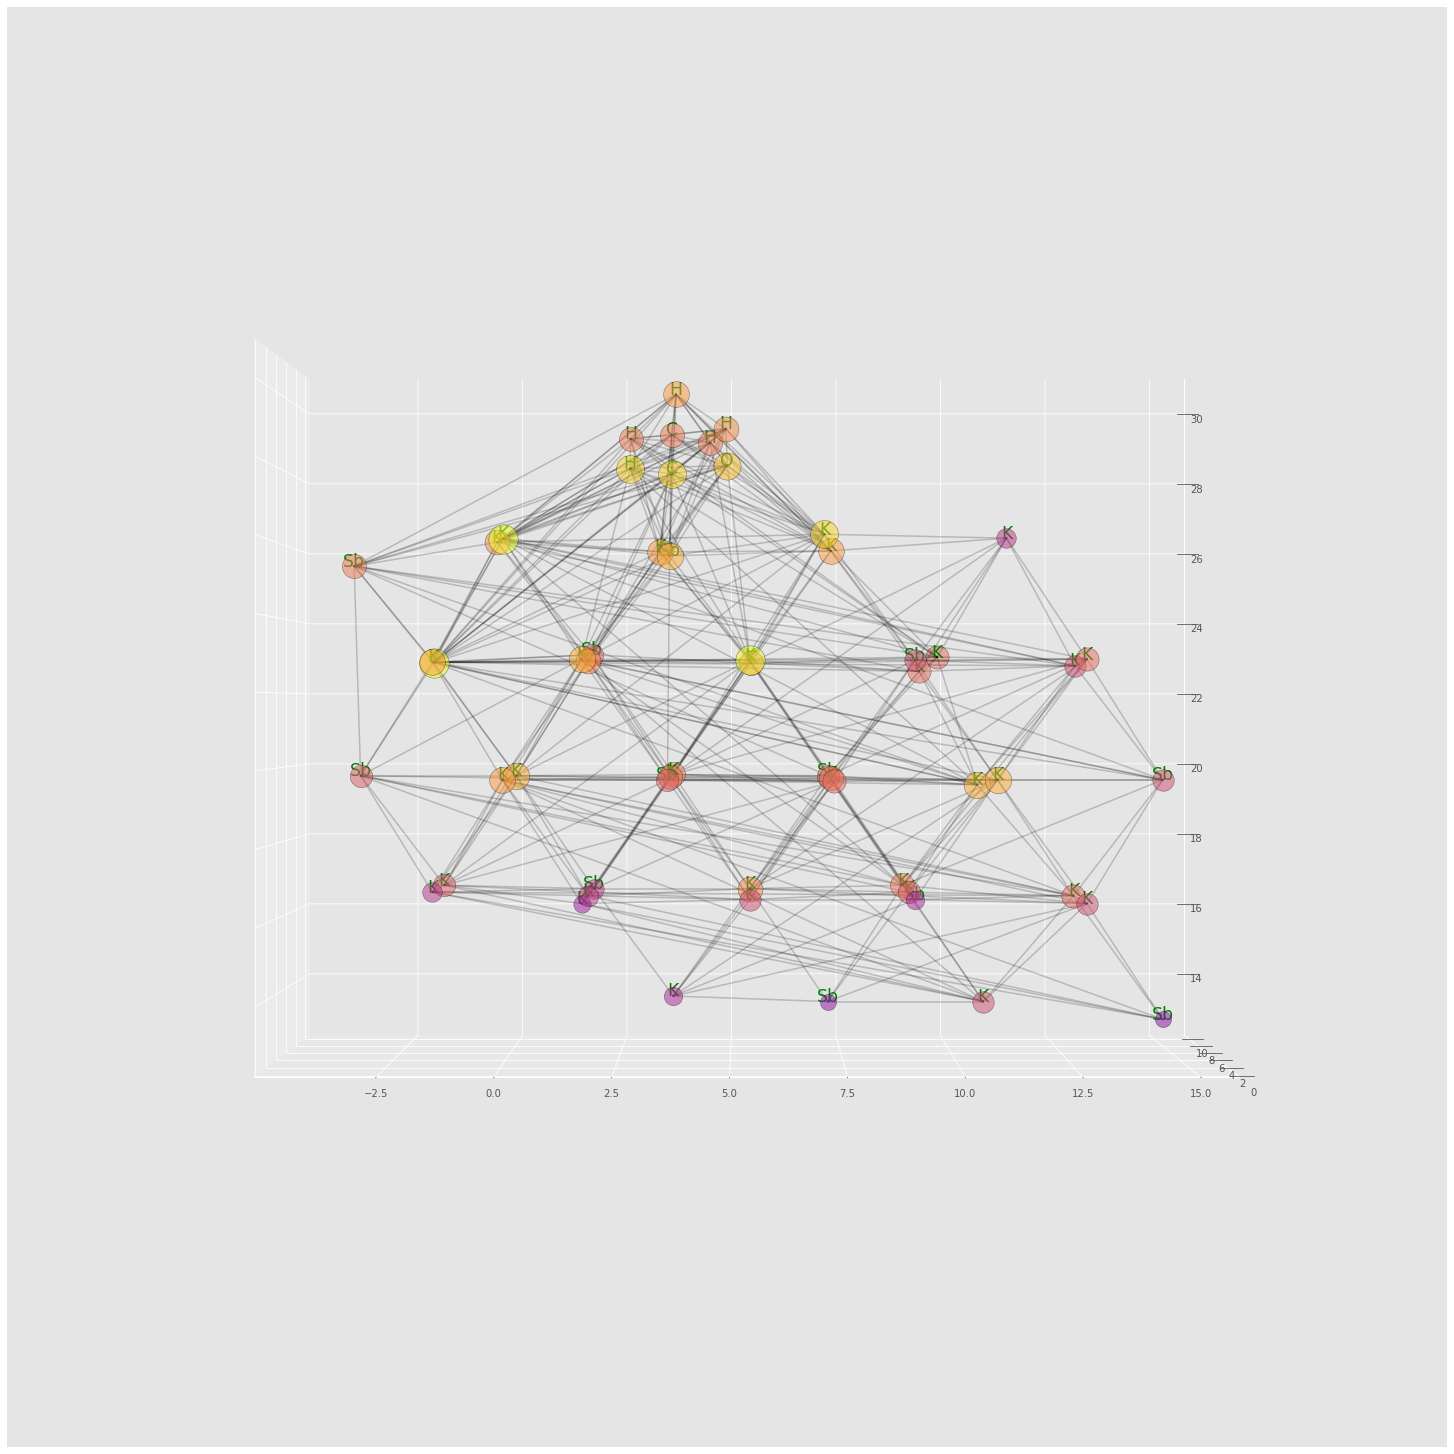

In [10]:
util_funcs.network_plot_3D(g_1, 180+90, save=False)

In [11]:
ag_og = [i.natoms for i in graph_data]
np.max(ag_og)
#graph_data[0].x.shape[]

224

In [12]:

embedding_size = np.max(ag_og) +15

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.seed()
        #torch.manual_seed(int(45))

        # GCN layers
        self.initial_conv = GCNConv((graph_data[0].x.shape[1]), embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 239)
  (conv1): GCNConv(239, 239)
  (conv2): GCNConv(239, 239)
  (conv3): GCNConv(239, 239)
  (out): Linear(in_features=478, out_features=1, bias=True)
)
Number of parameters:  174949


In [23]:
from torch_geometric.loader import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(graph_data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(graph_data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(graph_data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y.float()))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in tqdm(range(100)):
    loss, h = train(graph_data[:100])
    losses.append(loss)
    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")


Starting training...


  1%|          | 1/100 [00:28<47:16, 28.65s/it]

Epoch 0 | Train Loss 210.8692169189453


 11%|█         | 11/100 [05:12<42:35, 28.71s/it]

Epoch 10 | Train Loss 197.7786407470703


 21%|██        | 21/100 [10:13<37:56, 28.81s/it]

Epoch 20 | Train Loss 193.26492309570312


 31%|███       | 31/100 [13:29<22:45, 19.79s/it]

Epoch 30 | Train Loss 202.3190155029297


 41%|████      | 41/100 [16:45<19:26, 19.77s/it]

Epoch 40 | Train Loss 193.2626190185547


 51%|█████     | 51/100 [20:02<15:59, 19.57s/it]

Epoch 50 | Train Loss 278.9417419433594


 61%|██████    | 61/100 [23:18<12:44, 19.60s/it]

Epoch 60 | Train Loss 230.42300415039062


 71%|███████   | 71/100 [26:35<09:30, 19.68s/it]

Epoch 70 | Train Loss 177.98057556152344


 81%|████████  | 81/100 [29:52<06:13, 19.64s/it]

Epoch 80 | Train Loss 233.93594360351562


 91%|█████████ | 91/100 [33:09<02:57, 19.67s/it]

Epoch 90 | Train Loss 355.34490966796875


100%|██████████| 100/100 [36:05<00:00, 21.65s/it]


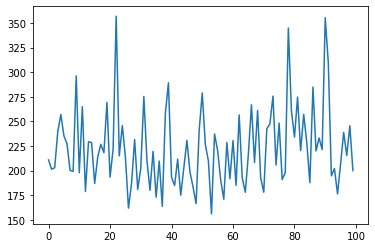

In [26]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)]
p = plt.plot(loss_indices, losses_float)
#plt = sns.lineplot(loss_indices, losses_float)
#plt